## Imports

In [129]:
from vit_pytorch.vit import ViT
from vit_pytorch.extractor import Extractor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from MyTransformer import MyTransformer

import torch
import torch.nn as nn
from torch import Tensor
from torchvision import transforms
from torch.nn import Transformer
import math
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import io
from torch.nn.utils.rnn import pad_sequence
from MyTransformer import MyTransformer
from torch.utils.data import DataLoader, Dataset
import numpy as np
from util.bleu import get_bleu
import os
import json
from PIL import Image

"""
Author: Philip Paterson
Referenced PyTorch documentation
"""

'\nAuthor: Philip Paterson\nReferenced PyTorch documentation\n'

In [140]:
class ImageCaptioner(nn.Module):
    def __init__(self, vocab_size):

        NUM_ENCODER_LAYERS = 3
        NUM_DECODER_LAYERS = 3
        EMB_SIZE = 512 # Embedding dimension: 512
        NHEAD = 8 # No. of Attention head: 8
        FFN_HID_DIM = 512 # Feedforward dimension: 512

        super(ImageCaptioner, self).__init__()

        self.v = ViT(
            image_size=256, #Size of the image
            patch_size=16, # number of patches
            num_classes=1000, #number of classes,
            dim=512, # Embedding dimension
            depth=1, # No of encoder layers
            heads=8, #No of MLP heads
            mlp_dim=512, # Dimension of Feedforwards
            dropout=0.1,
            emb_dropout=0.1
        )

        self.vision_encoder = Extractor(self.v)
        self.decode = MyTransformer(
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS,
            emb_size=EMB_SIZE,
            nhead=NHEAD,
            src_vocab_size=0,
            tgt_vocab_size=vocab_size,
            dim_feedforward=FFN_HID_DIM
        )

    def forward(self, src, trg, pad_idx : torch.Tensor):
        """ Forward method for transformer
        
        :param src: batch of images of shape 
            (Batch,Colorchannel,Height,Width)
        :param trg: Target input sequence, right-shifted by one
            Target batch matrix is (N_T - 1) x Batch Size
        :param pad_idx: padding index
        """
        # Here, src is the batch of images of shape 
        # (Batch,Colorchannel,Height,Width)
        logits, memory = self.vision_encoder(src)

        tgt_mask = MyTransformer.create_mask(self.decode, src, trg, pad_idx)

        outs = self.decode(self.decode, trg, memory.transpose(0, 1), tgt_mask)

        return self.generator(outs)
    

class DatasetFlickr8K(Dataset):
    def __init__(self, data, vocab, data_dir):
        self.data = data
        self.vocab = vocab
        self.data_dir = data_dir
        self.img_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
    
    def __len__(self) -> int:
        length = 0
        for img_data in self.data['images']:
            length += len(img_data['sentences'])
        return length

    def __getitem__(self, idx) -> tuple:
        index = idx

        # Loop through each image
        for img_data in self.data['images']:
            num_captions = len(img_data['sentences'])
            
            if index < num_captions:
                caption_counter = 0
                
                # Find the caption with the index associated with the image
                for caption in img_data['sentences']:
                    if caption_counter == index:
                        img_name = self.data_dir + 'Images/' + img_data['filename']
                
                        with Image.open(img_name) as raw_img:
                            transformed_img = self.img_transform(raw_img)

                        tokens = caption['tokens']

                        # Encode caption
                        encoded_caption = encode_tokens(tokens=tokens, vocab=self.vocab)
                    
                        return transformed_img, torch.tensor(encoded_caption)
                    caption_counter += 1
            
            # Decrement by the number of captions
            index -= num_captions
        
        # If the index is not found
        # Referenced https://docs.python.org/3/library/exceptions.html
        # for raising exceptions
        raise IndexError("ERROR: Invalid index; out of bounds")

# Functions on Getting Data
def build_vocab(filepath, tokenizer):
    my_counter = Counter()
    with io.open(filepath, encoding="utf8") as filehandle:
        for str in filehandle:
            my_counter.update(tokenizer(str))
    return Vocab(my_counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

def encode_tokens(tokens : list, vocab : dict) -> list:
    '''
    Encodes the given token sequence
    :param words: list of words
    :param vocab: vocab dictionary 
    '''
    tok_arr = [vocab['<bos>']]
    for token in tokens:
        if token in vocab:
            tok_arr.append(vocab[token])
        else:
            tok_arr.append(vocab['<unk>'])
    tok_arr.append(vocab['<eos>'])

    return tok_arr

def decode_tokens(tokenized_sentence, vocab):
    '''
    Takes a tokenized sentence and converts it to a sentence of words.
    '''

    reversed_vocab = {value: key for key, value in vocab.items()}

    # Build the translated sentence
    sentence = []
    for token in tokenized_sentence:
        word = reversed_vocab[token]
        if '<' not in word:
            sentence.append(word)

    return sentence

def tokenize_text(iterator, vocab, tokenizer) -> list:
    '''
    Tokenizes all sentences in the given iterator
    '''
    tokenized_text = []
    for sentence in iterator:
        tokenized_sentence = torch.Tensor(encode_tokens(sentence, vocab))
        tokenized_text.append(tokenized_sentence)
    return tokenized_text

def create_batch(each_data_batch, PAD_IDX):
    '''
    Creates a batch of the
    '''
    img_batch, caption_batch = [], []
    i = 0
    for (img, caption) in each_data_batch:
        img_batch.append(img)
        caption_batch.append(caption)
        i += 1

    # Pad the sequences
    caption_batch = pad_sequence(caption_batch, padding_value=PAD_IDX)

    # Tranpose the batch to have the batch dim int the first dimension
    caption_batch = caption_batch.transpose(0,1)

    return torch.stack(img_batch, dim=0), caption_batch


def get_dataloader(data : dict, vocab : dict, data_dir : str, batch_size : int) -> DataLoader:
    '''
    Helper function to create dataloader
    '''
    data = DatasetFlickr8K(
        data=data,
        vocab=vocab,
        data_dir=data_dir
    )

    # Return the dataloader
    dataloader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: create_batch(batch, vocab['<pad>'])
    )    

    return dataloader

def run_one_epoch(epoch_index : int, model, dataloader : DataLoader, loss_func, optimizer, pad_idx, split : str, device : str = 'cpu'):
    '''
    Performs one epoch of either training with backpropagation or validation or testing inference
    '''
    running_loss = 0.

    for src, tgt in dataloader:
        # Change the device and format
        tgt = tgt.type(torch.LongTensor)
        src = src.to(device=device)
        tgt = tgt.to(device=device)
        
        # Zero the gradients for every batch
        optimizer.zero_grad()

        tgt_input = tgt[:-1]
        tgt_out = tgt[1:]

        # Make the predictions from the forward pass
        logits = model(src=src, trg=tgt_input, pad_idx=torch.tensor(pad_idx, device=device))

        # Compute the loss
        loss = loss_func(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        
        # If we're training the model
        if split == 'TRAIN':
            # Compute loss gradients using backward
            loss.backward()

            # Make adjustments to the learning weights
            optimizer.step()

        # Sum the losses and accuracies
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)

    return avg_loss

def train(
        model: nn.Module,
        train_dataloader : DataLoader,
        valid_dataloader : DataLoader,
        test_dataloader : DataLoader,
        loss_func, optimizer,
        pad_idx,
        tgt_vocab,
        device = 'cpu'
    ):
    '''
    The main train function
    '''
    EPOCHS = 15

    # Referenced https://pieriantraining.com/reversing-keys-and-values-in-a-python-dictionary/ 
    # for reversing a dictionary
    reversed_tgt_vocab = {value: key for key, value in tgt_vocab.items()}
    
    # Initialize parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # Loop variables
    avg_train_losses = []
    avg_valid_losses = []
    bleu_scores = []
    best_bleu_score = 0

    for epoch in range(EPOCHS):
        print(f"---Epoch {epoch + 1}---")
        
        # Run the training
        model.train(True)
        
        avg_train_loss = run_one_epoch(
            epoch,
            model,
            train_dataloader,
            loss_func,
            optimizer,
            pad_idx,
            'TRAIN',
            device
        )
        
        # Evaluate the model off of the validation dataset
        model.eval()
        with torch.no_grad():
            avg_valid_loss = run_one_epoch(
                epoch,
                model,
                valid_dataloader,
                loss_func,
                optimizer,
                pad_idx,
                'VALID',
                device
            )

        # TODO: UNCOMMENT THE BLEU SCORES
        # # Calculate the bleu score
        # with torch.no_grad():
        #     bleu_score = calc_bleu_score(
        #         model=model,
        #         dataloader=test_dataloader,
        #         device=device,
        #         tgt_vocab=tgt_vocab,
        #         reversed_tgt_vocab=reversed_tgt_vocab
        #     )

        # # Save the best model parameters
        # if bleu_score > best_bleu_score:
        #     best_bleu_score = bleu_score
        #     torch.save(model.state_dict(), 'saved_model.pt')
        
        # Append the losses and bleu score
        avg_train_losses.append(avg_train_loss)
        avg_valid_losses.append(avg_valid_loss)
        # bleu_scores.append(bleu_score) # TODO: UNCOMMENT

        # Print the per epoch losses and accuracies
        print(f"Loss: | Train: {avg_train_loss:.5f} | Validation: {avg_valid_loss:.5f}")
        # print(f"BLEU Score: {bleu_score}") # TODO: UNCOMMENT
    
    stats = {
        'training' : {
            'losses' : avg_train_losses,
        },
        'validation' : {
            'losses' : avg_valid_losses,
        },
        'testing' : {
            'bleu' : bleu_scores
        },
        'epochs' : np.arange(1, EPOCHS+1).tolist()
    }

    return stats


## Main Function

In [131]:
# Training JSON file (‘training data.json’) contains 6000 entities
# validation JSON (‘val data.json’) contains 1000 entities
# test JSON (‘test data.json’) contains 500 entities
datapath = 'Final_Project_Spring_24/'
training_data_fname = 'training_data.json'
test_data_fname = 'test_data.json'
val_data_fname = 'val_data.json'
english_vocab_path = 'English_vocab.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [141]:
# Load the data
training_json = json.load(open(datapath + training_data_fname))
test_json = json.load(open(datapath + test_data_fname))
val_json = json.load(open(datapath + val_data_fname))

# Get the tokenizer
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Get the vocabulary
en_vocab = torch.load(english_vocab_path, en_tokenizer).stoi

# Get the padding index
pad_idx = en_vocab['<pad>']

# Get the dataloaders for train, test, and validation
train_dataloader = get_dataloader(
    data=training_json,
    vocab=en_vocab,
    data_dir=datapath,
    batch_size=BATCH_SIZE
)

test_dataloader = get_dataloader(
    data=test_json,
    vocab=en_vocab,
    data_dir=datapath,
    batch_size=BATCH_SIZE
)

valid_dataloader = get_dataloader(
    data=val_json,
    vocab=en_vocab,
    data_dir=datapath,
    batch_size=BATCH_SIZE
)

model = ImageCaptioner(vocab_size=len(en_vocab)).to(device)

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Train the model
stats = train(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    test_dataloader=test_dataloader,
    loss_func=loss_fn,
    optimizer=optimizer,
    pad_idx=pad_idx,
    tgt_vocab=en_vocab,
    device=device
)

# TODO: Test with test dataloader

/home/philip/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


---Epoch 1---


AttributeError: 'ImageCaptioner' object has no attribute 'generate_square_subsequent_mask'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([32, 3, 256, 256])
Captions shape: torch.Size([32, 23])


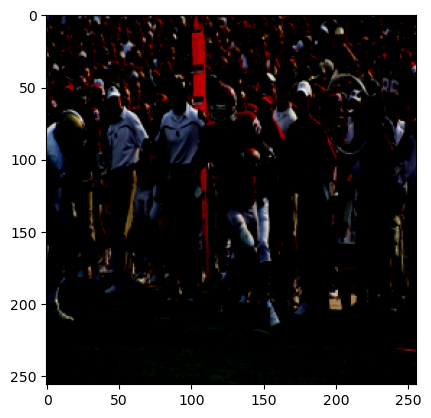

['the', 'football', 'player', 'is', 'trying', 'to', 'outrun', 'his', 'opponent']
Images shape: torch.Size([32, 3, 256, 256])
Captions shape: torch.Size([32, 25])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


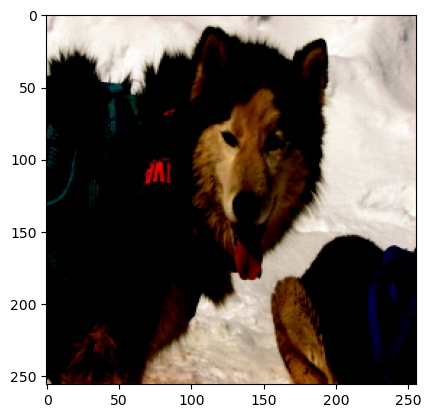

['a', 'husky', 'dog', 'wearing', 'the', 'gear', 'to', 'pull', 'a', 'sled']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([32, 3, 256, 256])
Captions shape: torch.Size([32, 20])


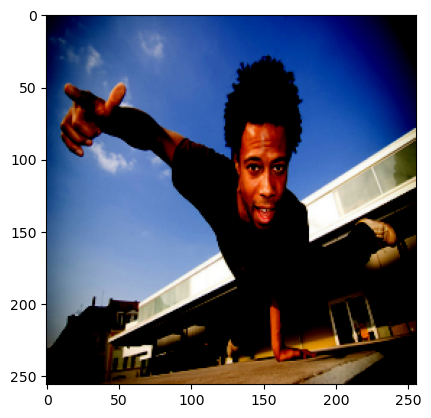

['a', 'young', 'man', 'jumps', 'on', 'a', 'table']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([32, 3, 256, 256])
Captions shape: torch.Size([32, 26])


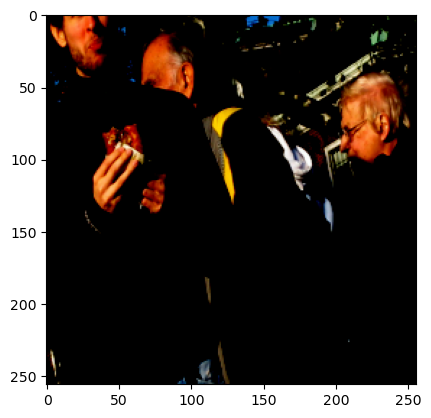

['a', 'guy', 'in', 'black', 'jacket', 'eating']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([32, 3, 256, 256])
Captions shape: torch.Size([32, 33])


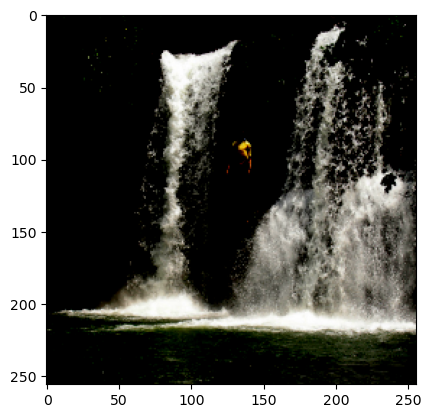

['a', 'person', 'wearing', 'a', 'yellow', 'shirt', 'just', 'jumped', 'from', 'the', 'top', 'of', 'the', 'waterfall']


In [ ]:
# Testing code

#Get the training data of the first training image
image_no = 6
data = training_json['images'][image_no]

#Access the filename and construct the full image path
img_name = datapath + 'Images/' + data['filename']

#Get the token array of the third caption of the first training image
caption_id = 2 # Should be in the range of 0-4
tokens = data['sentences'][caption_id]['tokens']

# Test Prints
img = mpimg.imread(img_name)
# imgplot = plt.imshow(img)


fig = plt.figure()

# Sampling function for testing TODO: Remove
for i, sample in enumerate(train_dataloader):
    images, captions = sample
    print("Images shape:", images.shape)
    print("Captions shape:", captions.shape)
    
    # Convert the tensor to a numpy array
    img_np = images[0].numpy()

    # Transpose the dimensions for imshow
    img_np = np.transpose(img_np, (1, 2, 0))
    # Display the image
    plt.imshow(img_np)
    plt.show()
    print(decode_tokens(captions[0].tolist(),en_vocab))
    if i == 4:
        break